# Using Python Libraries

In [32]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Define dataset path

In [3]:
data_dir = './dataset_cancer_v1/classificacao_binaria'
magnifications = ['40X', '100X', '200X', '400X']
classes = ['benign', 'malignant']

# Function to load and visualize images

In [4]:
def load_and_visualize_images(data_dir, magnifications, classes, img_count=5):
    rows = len(magnifications) * 2
    cols = img_count
    fig, axes = plt.subplots(rows, cols, figsize=(10, 20))
    fig.suptitle("Breast Cancer Histopathological Images", fontsize=20)
    
    for i, mag in enumerate(magnifications):
        for j, cls in enumerate(classes):
            folder_path = os.path.join(data_dir, mag, cls)
            images = os.listdir(folder_path)[:img_count]
            row_index = i * 2 + j
            
            for k, img_name in enumerate(images):
                img_path = os.path.join(folder_path, img_name)
                img = load_img(img_path, target_size=(150, 150))
                img_array = img_to_array(img)
                ax = axes[row_index, k]
                ax.imshow(img_array.astype('uint8'))
                ax.axis('off')
                ax.set_title(f'{mag}-{cls}', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Load and visualize

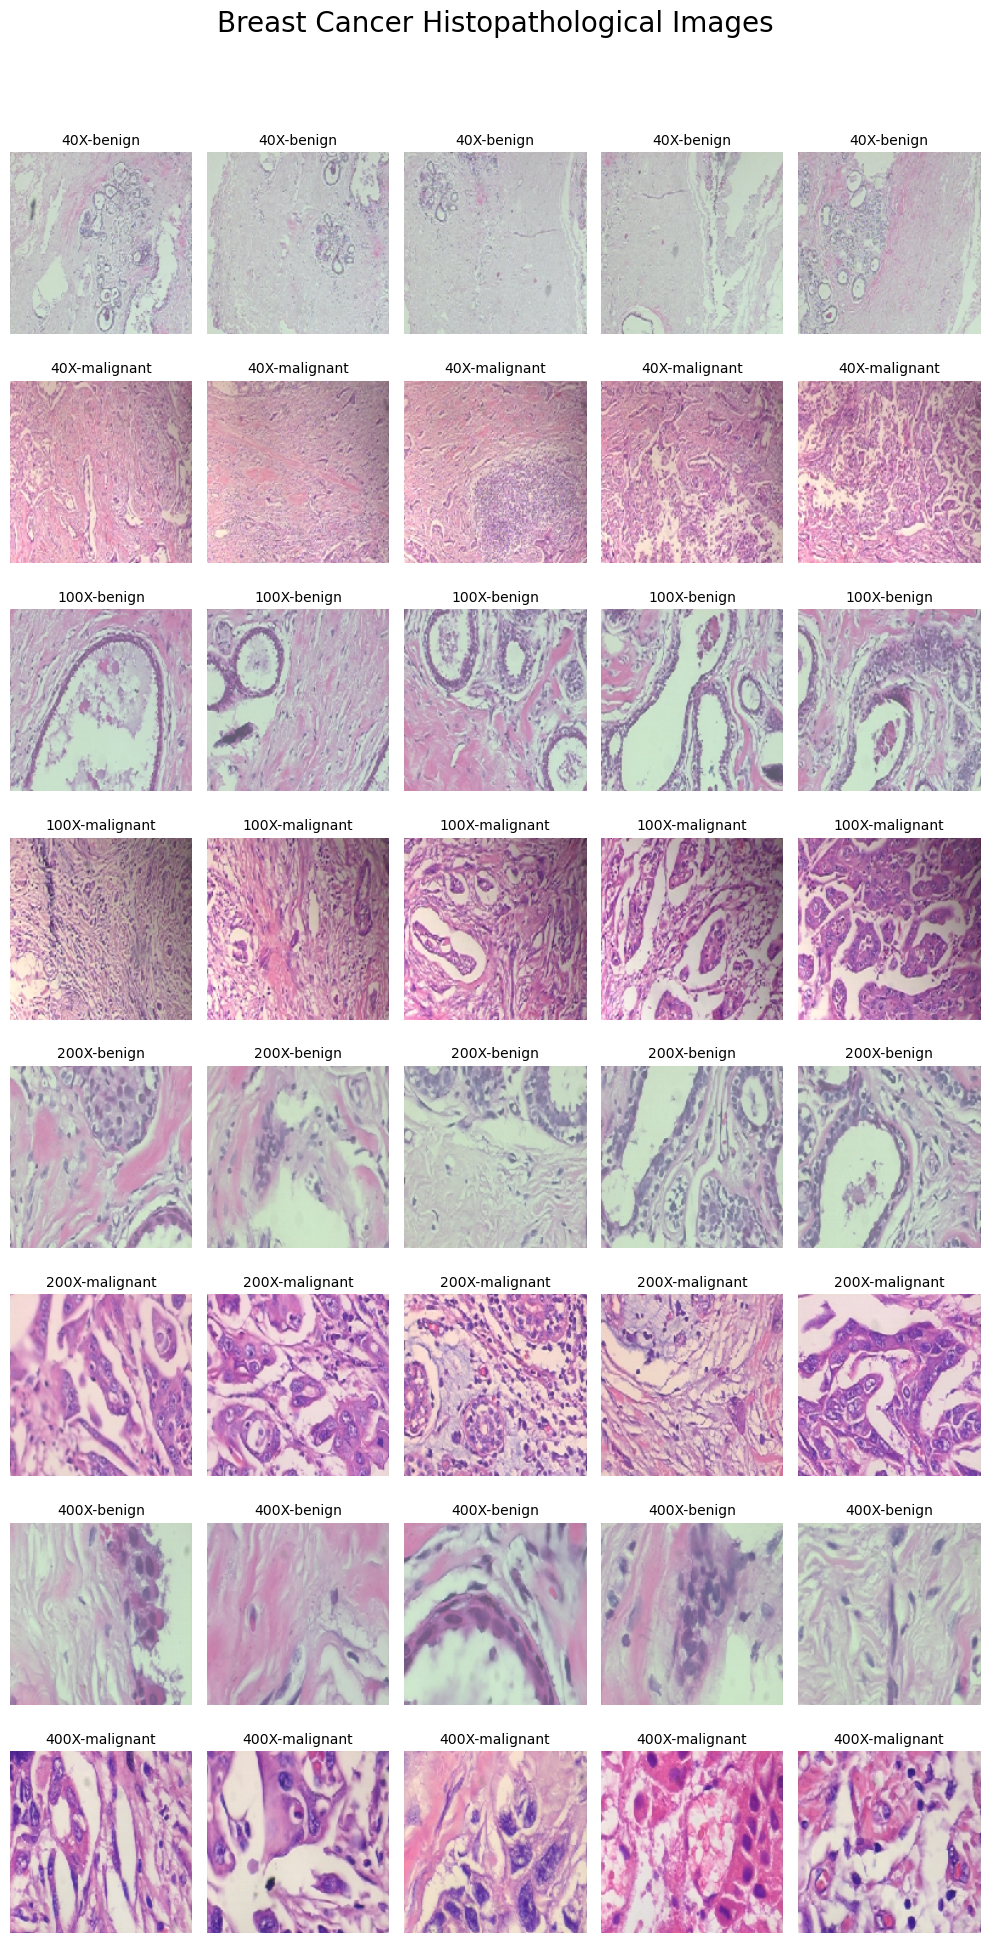

In [5]:
load_and_visualize_images(data_dir, magnifications, classes, img_count=5)

# Function to display number of images

In [6]:
def display_image_counts(data_dir, magnifications, classes):
    print("Number of Images in Each Folder:\n")
    for mag in magnifications:
        for cls in classes:
            folder_path = os.path.join(data_dir, mag, cls)
            num_images = len(os.listdir(folder_path))
            print(f'{mag} - {cls}: {num_images} images')

# Display image counts

In [7]:
display_image_counts(data_dir, magnifications, classes)

Number of Images in Each Folder:

40X - benign: 625 images
40X - malignant: 1370 images
100X - benign: 644 images
100X - malignant: 1437 images
200X - benign: 623 images
200X - malignant: 1390 images
400X - benign: 588 images
400X - malignant: 1232 images


# Restructure the Dataset

In [8]:
def restructure_dataset(original_data_dir, new_data_dir, magnifications, classes):
    os.makedirs(new_data_dir, exist_ok=True)
    for cls in classes:
        cls_dir = os.path.join(new_data_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)
        for mag in magnifications:
            src_dir = os.path.join(original_data_dir, mag, cls)
            if not os.path.exists(src_dir):
                print(f"Warning: {src_dir} does not exist.")
                continue
            for filename in os.listdir(src_dir):
                src_file = os.path.join(src_dir, filename)
                dst_file = os.path.join(cls_dir, filename)
                shutil.copy(src_file, dst_file)
    print("Dataset restructuring complete.")

# Define paths

In [9]:
original_data_dir = './dataset_cancer_v1/classificacao_binaria'
new_data_dir = './dataset_cancer_v1/binary_classification'
magnifications = ['40X', '100X', '200X', '400X']
classes = ['benign', 'malignant']

In [10]:
restructure_dataset(original_data_dir, new_data_dir, magnifications, classes)

Dataset restructuring complete.


# Define image size and other parameters

In [11]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Create ImageDataGenerator instances

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode="nearest"
)

# Training generator

In [13]:
train_generator = train_datagen.flow_from_directory(
    new_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 6328 images belonging to 2 classes.


# Validation generator

In [14]:
validation_generator = train_datagen.flow_from_directory(
    new_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 1581 images belonging to 2 classes.


In [15]:
# Check class indices
print("Class Indices:", train_generator.class_indices)

Class Indices: {'benign': 0, 'malignant': 1}


# Building the VGG16 Model

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

In [17]:
# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# Display the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stop, reduce_lr]

In [22]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 593s 3s/step - accuracy: 0.6877 - loss: 0.6226 - val_accuracy: 0.6862 - val_loss: 0.6646 - learning_rate: 1.0000e-04
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8438 - loss: 0.4557 - val_accuracy: 1.0000 - val_loss: 0.3262 - learning_rate: 1.0000e-04
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.7198 - loss: 0.5618 - val_accuracy: 0.6601 - val_loss: 0.7004 - learning_rate: 1.0000e-04
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8125 - loss: 0.3767 - val_accuracy: 1.0000 - val_loss: 0.3078 - learning_rate: 1.0000e-04
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.7537 - loss: 0.5157 - val_accuracy: 0.6205 - val_loss: 0.7176 - learning_rate: 1.0000e-04
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7812 - loss: 0.5247 - val_accuracy: 1.0000 - val_loss: 0.3155 - learning_rate: 1.0000e-04
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 609s 3s/step - accura

In [23]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True


In [24]:
# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
# Continue training
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)

Epoch 13/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.8056 - loss: 0.4313 - val_accuracy: 0.7003 - val_loss: 0.6619 - learning_rate: 1.0000e-05
Epoch 14/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9375 - loss: 0.2108 - val_accuracy: 1.0000 - val_loss: 0.0820 - learning_rate: 1.0000e-05
Epoch 15/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.8713 - loss: 0.3110 - val_accuracy: 0.6837 - val_loss: 0.6456 - learning_rate: 1.0000e-05
Epoch 16/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7500 - loss: 0.5390 - val_accuracy: 1.0000 - val_loss: 0.0658 - learning_rate: 1.0000e-05
Epoch 17/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.8852 - loss: 0.2790 - val_accuracy: 0.7545 - val_loss: 0.5713 - learning_rate: 1.0000e-05
Epoch 18/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9062 - loss: 0.2660 - val_accuracy: 1.0000 - val_loss: 0.0385 - learning_rate: 1.0000e-05
Epoch 19/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step -

In [26]:
# Predict classes
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
y_pred = (Y_pred > 0.5).astype(int)

49/49 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step


In [27]:
# True labels
y_true = validation_generator.classes[:len(y_pred)]

In [30]:
# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      benign       0.69      0.34      0.46       496
   malignant       0.75      0.93      0.83      1072

    accuracy                           0.74      1568
   macro avg       0.72      0.63      0.64      1568
weighted avg       0.73      0.74      0.71      1568



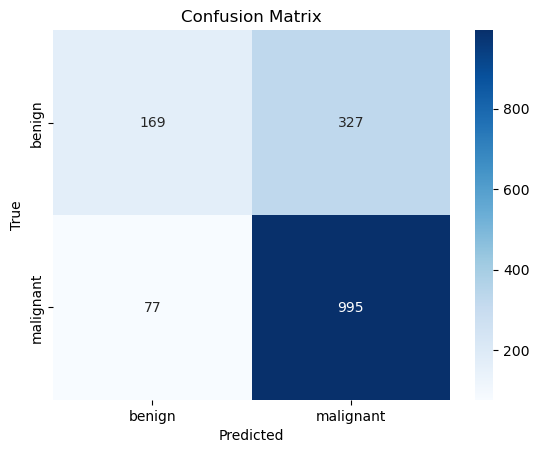

In [33]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Retrieve Class Indices and Labels

# Get the mapping from class indices to class labels
class_indices = train_generator.class_indices
# Reverse the dictionary to get labels from indices
labels = dict((v, k) for k, v in class_indices.items())

print("Class Indices:", class_indices)
print("Label Mapping:", labels)

Class Indices: {'benign': 0, 'malignant': 1}
Label Mapping: {0: 'benign', 1: 'malignant'}


In [39]:
# Fetch a Batch of Validation Images

# Reset the validation generator to start from the first batch
validation_generator.reset()

# Fetch one batch of images and labels
images, true_labels = next(validation_generator)

print(f"Batch size: {images.shape[0]}")
print(f"Image shape: {images.shape[1:]}")  # e.g., (224, 224, 3)
print(f"True labels (first 9): {true_labels[:9]}")

Batch size: 32
Image shape: (224, 224, 3)
True labels (first 9): [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [40]:
# Make predictions on the batch
predictions = model.predict(images)
# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

print(f"Predictions (first 9): {predicted_labels[:9]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions (first 9): [0 1 0 0 0 1 1 1 1]


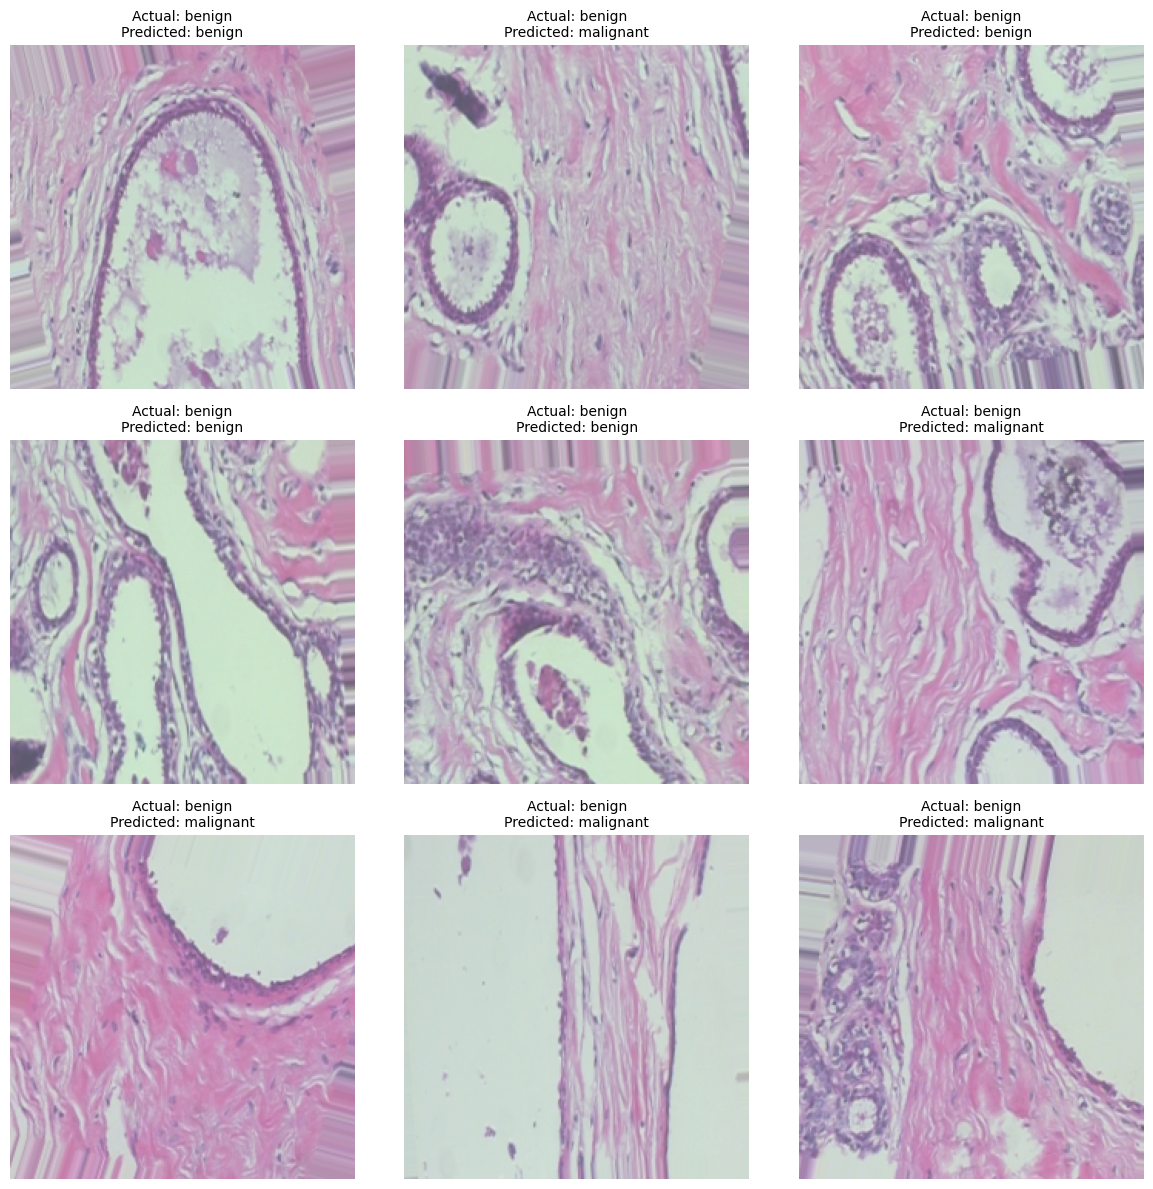

In [41]:
# Number of images to display
num_images = 9

# Create a figure with 3x3 subplots
plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    # Display the image
    plt.imshow(images[i])
    plt.axis('off')
    
    # Get the actual and predicted labels
    actual = labels[true_labels[i]]
    predicted = labels[predicted_labels[i]]
    
    # Set the title with actual and predicted labels
    plt.title(f"Actual: {actual}\nPredicted: {predicted}", fontsize=10)
    
plt.tight_layout()
plt.show()